# Train Predict Next Play Model

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split

from train_tools import SCALER_SUFFIX

from train_tools import acquire_data, get_config_value
from train_tools import scale_int_values, extract_categorical_columns
from train_tools import replace_populated_values_with_tf_num
from train_tools import model_train, save_model, evaluate_model

In [2]:
DEFAULT_DB_CONNECTION_STRING = "postgresql://baseball_app:baseball123@db/baseball_db"
ENV_DB_CONNECTION_STRING = "DB_CONNECTION_STRING"

DEFAULT_OUTPUT_DIR = "../../../target/models/predict_play/"
ENV_OUTPUT_DIR = "OUTPUT_DIR"

ONNX_FILENAME = "model.onnx"
ROC_IMAGE_NAME = "roc.jpg"

ENV_DATASET_SIZE = "DATASET_SIZE"
DEFAULT_DATASET_SIZE = 5000

NEURAL_NETWORK_WIDTH = 10

In [3]:
output_dir_configured = get_config_value(ENV_OUTPUT_DIR, DEFAULT_OUTPUT_DIR)
output_dir = os.path.abspath(output_dir_configured)
print ("Output Directory: " + output_dir)

# ensure the model directory exists
if not os.path.exists(output_dir):
    print ("Creating output directory: " + output_dir)
    os.makedirs(output_dir)

Output Directory: /opt/app-root/src/baseball/target/models/predict_play


## Acquire Data

Pull relevant attributes from the baseball database as a DataFrame for analysis and training.

In [4]:
dataset_size = get_config_value(ENV_DATASET_SIZE, DEFAULT_DATASET_SIZE)
if dataset_size is not None and isinstance(dataset_size, str) and len(dataset_size) > 0:
    dataset_size = int(dataset_size)
print ("Data Set Size: " + str(dataset_size))

Data Set Size: 5000


In [5]:
sql = """
        select random() as r_id, game_play_atbat.player_code as player_code, pitch_index, home_team_flag, game_play_atbat.score_home as score_home, game_play_atbat.score_visitor as score_visitor, sky, night_flag, temperature, wind_direction, wind_speed, precipitation, field_condition, roster_batter.batting_hand as batting_hand, roster_pitcher.throw_hand as pitching_hand, runner_1b, runner_2b, runner_3b, primary_play_type_cd, outs, pitch_count
        from game, game_play, game_play_atbat, game_play_atbat_pitch, roster as roster_batter, roster as roster_pitcher
        where game.game_id = game_play.game_id
        and game_play_atbat.game_play_id = game_play.game_play_id
        and game_play_atbat_pitch.game_play_id = game_play.game_play_id     
        and roster_batter.player_code = game_play_atbat.player_code
        and roster_batter.season_year = date_part('year', game.game_date)
        and roster_pitcher.player_code = game_play_atbat.pitcher
        and roster_pitcher.season_year = roster_batter.season_year
        order by r_id        
      """

db_conn_str = get_config_value(ENV_DB_CONNECTION_STRING, DEFAULT_DB_CONNECTION_STRING)
full_df = acquire_data(db_conn_str, sql, dataset_size)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   r_id                  5000 non-null   float64
 1   player_code           5000 non-null   object 
 2   pitch_index           5000 non-null   int64  
 3   home_team_flag        5000 non-null   bool   
 4   score_home            5000 non-null   int64  
 5   score_visitor         5000 non-null   int64  
 6   sky                   5000 non-null   object 
 7   night_flag            5000 non-null   bool   
 8   temperature           5000 non-null   int64  
 9   wind_direction        5000 non-null   object 
 10  wind_speed            5000 non-null   int64  
 11  precipitation         5000 non-null   object 
 12  field_condition       5000 non-null   object 
 13  batting_hand          5000 non-null   object 
 14  pitching_hand         5000 non-null   object 
 15  runner_1b            

In [6]:
def calculate_score_deficit(row):
    is_home = row["home_team_flag"]
    score_home = row["score_home"]
    score_visitor = row["score_visitor"]

    if is_home:
        return score_home - score_visitor
    else:
        return score_visitor - score_home

full_df['score_deficit'] = full_df.apply(lambda x: calculate_score_deficit(x), axis=1)

In [7]:
full_df.head()

,r_id,player_code,pitch_index,home_team_flag,score_home,score_visitor,sky,night_flag,temperature,wind_direction,...,field_condition,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,primary_play_type_cd,outs,pitch_count,score_deficit
0,9.896345e-08,floyc001,2,True,15,3,cloudy,True,74,tocf,...,unknown,R,R,lee-d002,None,None,D,2,70,12
1,1.071822e-07,bakej001,3,False,1,2,sunny,False,79,fromrf,...,unknown,R,R,soria001,None,None,D,2,69,1
2,2.560279e-07,millb002,1,True,0,0,cloudy,False,81,tocf,...,unknown,R,L,None,None,None,D,2,3,0
3,2.669511e-07,cabrm001,1,False,1,0,sunny,True,73,rtol,...,unknown,R,L,None,None,None,D,2,13,-1
4,3.093264e-07,vizqo001,4,True,6,9,cloudy,True,70,fromcf,...,unknown,R,R,None,None,None,D,3,142,-3


## Prepare Data for Model Training

Prepare data for classification.

In [8]:
# focus data frame on prediction values
# - maybes - wind_direction, home_team_flag, night_flag
df = full_df[["pitch_index", "pitch_count", "batting_hand", "pitching_hand", "runner_1b", "runner_2b", "runner_3b", "outs", "score_deficit", "primary_play_type_cd"]]

df = df.convert_dtypes()
df.head()

,pitch_index,pitch_count,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,outs,score_deficit,primary_play_type_cd
0,2,70,R,R,lee-d002,<NA>,<NA>,2,12,D
1,3,69,R,R,soria001,<NA>,<NA>,2,1,D
2,1,3,R,L,<NA>,<NA>,<NA>,2,0,D
3,1,13,R,L,<NA>,<NA>,<NA>,2,-1,D
4,4,142,R,R,<NA>,<NA>,<NA>,3,-3,D


In [9]:
scale_int_values(df, 'pitch_index', 'pitch_index_scaled', True,
                 output_dir + "/" + "pitch_index" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_count', 'pitch_count_scaled', True,
                 output_dir + "/" + "pitch_count" + SCALER_SUFFIX)
scale_int_values(df, 'score_deficit', 'score_deficit_scaled', True,
                 output_dir + "/" + "score_deficit" + SCALER_SUFFIX)

replace_populated_values_with_tf_num(df, 'runner_1b', 'is_runner_1b', True)
replace_populated_values_with_tf_num(df, 'runner_2b', 'is_runner_2b', True)
replace_populated_values_with_tf_num(df, 'runner_3b', 'is_runner_3b', True)

df = extract_categorical_columns(df, ["batting_hand", "pitching_hand", "outs", "primary_play_type_cd"])

df.head()


,pitch_index_scaled,pitch_count_scaled,score_deficit_scaled,is_runner_1b,is_runner_2b,is_runner_3b,batting_hand_L,batting_hand_R,pitching_hand_B,pitching_hand_L,...,primary_play_type_cd_G,primary_play_type_cd_H,primary_play_type_cd_I,primary_play_type_cd_K,primary_play_type_cd_L,primary_play_type_cd_N,primary_play_type_cd_O,primary_play_type_cd_P,primary_play_type_cd_W,primary_play_type_cd_X
0,-0.560133,-0.110269,3.871275,1,0,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.061261,-0.131894,0.328452,1,0,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-1.059004,-1.559129,0.006377,0,0,0,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,-1.059004,-1.342882,-0.315698,0,0,0,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0.437610,1.446715,-0.959847,0,0,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pitch_index_scaled      5000 non-null   float64
 1   pitch_count_scaled      5000 non-null   float64
 2   score_deficit_scaled    5000 non-null   float64
 3   is_runner_1b            5000 non-null   int64  
 4   is_runner_2b            5000 non-null   int64  
 5   is_runner_3b            5000 non-null   int64  
 6   batting_hand_L          5000 non-null   boolean
 7   batting_hand_R          5000 non-null   boolean
 8   pitching_hand_B         5000 non-null   boolean
 9   pitching_hand_L         5000 non-null   boolean
 10  pitching_hand_R         5000 non-null   boolean
 11  outs_0                  5000 non-null   bool   
 12  outs_1                  5000 non-null   bool   
 13  outs_2                  5000 non-null   bool   
 14  outs_3                  5000 non-null   

## Train Model

Train a classification model using the prepared data set.

In [11]:
df["pitch_index_scaled"].describe()

count    5.000000e+03
mean     8.384404e-17
std      1.000100e+00
min     -1.059004e+00
25%     -5.601327e-01
50%     -6.126140e-02
75%      4.376099e-01
max      6.424066e+00
Name: pitch_index_scaled, dtype: float64

In [12]:
size_x = 15
size_y = df.shape[1] - size_x
print(f"Number of Features (X): {size_x}")
print(f"Length of Outputs (y): {size_y}")

print("Columns and their respective order for inferences:")
df.columns[0:size_x]

Number of Features (X): 15
Length of Outputs (y): 20
Columns and their respective order for inferences:


Index(['pitch_index_scaled', 'pitch_count_scaled', 'score_deficit_scaled',
       'is_runner_1b', 'is_runner_2b', 'is_runner_3b', 'batting_hand_L',
       'batting_hand_R', 'pitching_hand_B', 'pitching_hand_L',
       'pitching_hand_R', 'outs_0', 'outs_1', 'outs_2', 'outs_3'],
      dtype='object')

In [13]:
df = df.convert_dtypes()
print("Model Inputs:")
df.info()

# Extract data
X = df.iloc[:, 0:size_x]
y = df.iloc[:, size_x:]

Model Inputs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pitch_index_scaled      5000 non-null   Float64
 1   pitch_count_scaled      5000 non-null   Float64
 2   score_deficit_scaled    5000 non-null   Float64
 3   is_runner_1b            5000 non-null   Int64  
 4   is_runner_2b            5000 non-null   Int64  
 5   is_runner_3b            5000 non-null   Int64  
 6   batting_hand_L          5000 non-null   boolean
 7   batting_hand_R          5000 non-null   boolean
 8   pitching_hand_B         5000 non-null   boolean
 9   pitching_hand_L         5000 non-null   boolean
 10  pitching_hand_R         5000 non-null   boolean
 11  outs_0                  5000 non-null   boolean
 12  outs_1                  5000 non-null   boolean
 13  outs_2                  5000 non-null   boolean
 14  outs_3                  50

In [14]:
# Convert to 2D PyTorch tensors
Xt = torch.tensor(X.values.astype(float), dtype=torch.float32)
yt = torch.tensor(y.values.astype(bool), dtype=torch.float32)


In [15]:
class PitchPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(size_x, size_x*NEURAL_NETWORK_WIDTH)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(size_x*NEURAL_NETWORK_WIDTH, size_x*NEURAL_NETWORK_WIDTH)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(size_x*NEURAL_NETWORK_WIDTH, size_x*NEURAL_NETWORK_WIDTH)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(size_x*NEURAL_NETWORK_WIDTH, size_y)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [16]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.7, shuffle=True)
print ("Training Shapes: X_train=" + str(X_train.shape) + " y_train=" + str(y_train.shape) + " X_test=" + str(X_test.shape) + " y_test=" + str(y_test.shape))

Training Shapes: X_train=torch.Size([3500, 15]) y_train=torch.Size([3500, 20]) X_test=torch.Size([1500, 15]) y_test=torch.Size([1500, 20])


In [17]:
model = PitchPredictionModel()
final_acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {final_acc*100:.2f}%")

Final model accuracy: 95.85%


ROC Image Output Filename: /opt/app-root/src/baseball/target/models/predict_play/roc.jpg
Model Outputs:
['Stolen Base', 'Single', 'Double', 'Triple', 'Base Runner Advance', 'Caught Stealing', 'Fielders Choice', 'Defensive Play', 'Defensive Error', 'Fly Ball Error', 'Ground Rule Double', 'Homerun', 'Catcher Interference', 'Strikeout', 'Wild Pitch', 'Defensive Indifference', 'Passed Ball', 'Picked Off', 'Walk', 'Hit By Pitch']
[ 0.93648124 -1.494255    0.00637708  1.          0.          0.
  0.          1.          0.          1.          0.          0.
  0.          1.          0.        ] -> [2.7943415e-07 3.1423387e-01 5.3111004e-09 1.9269477e-07 1.2367434e-04
 2.9763320e-05 7.7014643e-04 1.8490867e-01 1.0616850e-02 5.6932120e-05
 1.3964963e-09 1.2291244e-05 1.3286382e-04 1.5902114e-01 7.2774452e-07
 1.6688109e-12 4.1377899e-12 9.1130332e-06 3.2410383e-01 3.0691311e-02] (expected [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])
[ 0.93648124  1.2953416  -1.6039971   1.  

/opt/app-root/src/venv/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/src/venv/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/src/venv/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/src/venv/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


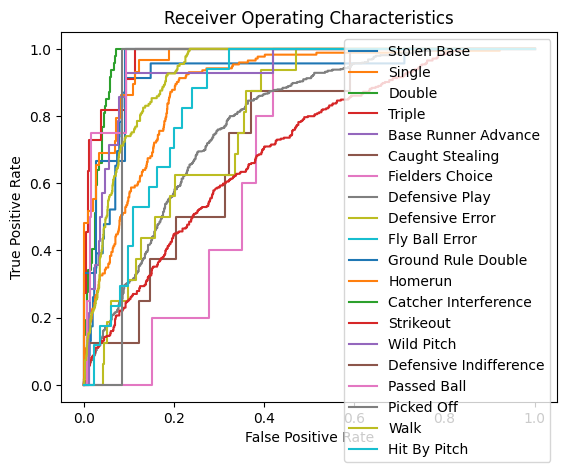

In [19]:
output_filename = output_dir + "/" + ROC_IMAGE_NAME
print("ROC Image Output Filename: " + output_filename)

db_conn_str_sqlalchamy = db_conn_str.replace("postgresql://", "postgresql+psycopg://")
play_types_df = pd.read_sql("select play_type_cd, play_type_desc from play_type order by play_type_cd", db_conn_str_sqlalchamy)

y_column_names = df.columns[size_x:].values
y_column_descriptions = [play_types_df.loc[play_types_df['play_type_cd'] == c.replace("primary_play_type_cd_", ""), 'play_type_desc'].values[0] for c in y_column_names ]

print("Model Outputs:")
print (y_column_descriptions)

evaluate_model(model, X_test, y_test, output_filename, y_column_descriptions)

## Save the model

Save the model to disk for use by an inference service.

In [20]:
output_filename = output_dir + "/" + ONNX_FILENAME
print ("ONNX Model Output Filename: " + output_filename)
save_model(model, size_x, output_filename)

ONNX Model Output Filename: /opt/app-root/src/baseball/target/models/predict_play/model.onnx
